In [1]:
#Read the data files
import pandas as pd

tensorflow_commits = pd.read_csv('/home/kc/Projects/data_files/tensorflow.csv')
vscode_commits=pd.read_csv('/home/kc/Projects/data_files/vscode.csv')
react_commits=pd.read_csv('/home/kc/Projects/data_files/react-native.csv')

total_commits=tensorflow_commits.append(vscode_commits, ignore_index=True)
total_commits=total_commits.append(react_commits, ignore_index=True)
                             

#total_commits.shape

In [2]:
total_commits.shape
#tensorflow_commits.shape
#vscode_commits.shape
#react_commits.shape
#total_commits.columns


(709762, 21)

In [3]:
#Creating various features for each modification

total_commits['total_changed'] = total_commits['lines_added']+total_commits['lines_removed']
total_commits['size'].loc[total_commits['size'] == 0] = total_commits['total_changed']
total_commits['ratio_changed'] = total_commits['total_changed']/total_commits['size']
total_commits['rated_complexity'] = total_commits['ratio_changed']*total_commits['complexity']
total_commits['total_dmm_size'] = total_commits['total_changed']*total_commits['dmm_unit_size']
total_commits['total_dmm_unit_complexity'] = total_commits['total_changed']*total_commits['dmm_unit_complexity']
total_commits['total_dmm_unit_interfacing'] = total_commits['total_changed']*total_commits['dmm_unit_interfacing']
total_commits['scaled_rated_complexity']=total_commits['rated_complexity']*total_commits['no._of_mod_files']

/home/kc/Projects/20200724_h2o4gpu/20200724_h2o4gpu/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
# Preprocessing the data. ML requires the data to be converted to numericals
#ml_commits = total_commits[['hash','Author', 'no._of_mod_files', 'dmm_unit_size',
#       'dmm_unit_complexity', 'dmm_unit_interfacing', 'complexity', 'functions', 'lines_added', 'lines_removed', 
#       'tokens', 'type']]

ml_commits = total_commits[['hash','Author','total_changed','ratio_changed','rated_complexity',
                            'total_dmm_unit_complexity','total_dmm_size','total_dmm_unit_interfacing', 'scaled_rated_complexity']]

# Resetting the frame's index. It is required to retain the integrity of the frame
ml_commits = ml_commits.reset_index().drop(columns = 'index')

# Temporarily dropping text columns for numeric processing
ml_commits_noText = ml_commits.drop(columns = ['Author','hash'])

# Explicitely converting fields to numeric types and filling the NaNs with zeros
ml_commits_numeric = ml_commits_noText.apply(pd.to_numeric,errors ='coerce').fillna(0)

# Adding the Author column back to create a 'total' data frame
ml_commits_total = ml_commits_numeric.copy()
ml_commits_total['Author'] = ml_commits['Author']
ml_commits_total['hash'] = ml_commits['hash']

In [5]:
# Remove outliers. 
from scipy import stats
import numpy as np

# Calculate z_scores (and if zscore is greater than '3', then its an outlier) and collect normal subset.
ml_commits_nout = ml_commits_total[(np.abs(stats.zscore(ml_commits_total.select_dtypes(exclude='object'))) < 3).all(axis=1)]
ml_commits_nout.to_csv('/home/kc/junk/vscode_nout.csv')

# Collect outliers
ml_commits_out = ml_commits_total[~(np.abs(stats.zscore(ml_commits_total.select_dtypes(exclude='object'))) < 3).all(axis=1)]
ml_commits_out.to_csv('/home/kc/junk/vscode_out.csv')

In [6]:
# Applying scaler to regular data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

# Use minMax scaler since this does not distort
# https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
scaler = MinMaxScaler()
ml_commits_nout_numeric = ml_commits_nout.drop(columns = ['Author','hash'])
data_scaled = scaler.fit_transform(ml_commits_nout_numeric)

In [ ]:
# Try and figure out how many clusters are optimum
# Plot the inertia curve to find the 'elbow'
from sklearn.cluster import KMeans

SSE = []

for cluster in range(1,20):
    %time kmeans_ss = KMeans(n_clusters = cluster, init='k-means++', random_state = 42)
    kmeans_ss.fit(data_scaled)
    SSE.append(kmeans_ss.inertia_)

    # converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

CPU times: user 2.82 s, sys: 163 ms, total: 2.99 s
Wall time: 764 ms
[[0.01250434 0.02270683 0.00418839 0.00703326 0.005411   0.00757717
  0.00141471]]
1
[None]
CPU times: user 2.17 s, sys: 15.3 ms, total: 2.19 s
Wall time: 176 ms
[[0.0053144  0.00719699 0.00190368 0.00257497 0.00193582 0.00284498
  0.00030567]
 [0.04967003 0.10287902 0.01599837 0.03007867 0.02337463 0.03203843
  0.00714742]]
2
[None, None]
CPU times: user 4.58 s, sys: 13.2 ms, total: 4.59 s
Wall time: 374 ms
[[0.00541355 0.00684836 0.00198619 0.00267189 0.00200279 0.00294785
  0.0003187 ]
 [0.03393332 0.10287609 0.00991799 0.01894118 0.01448535 0.02021075
  0.00410049]
 [0.30277824 0.09875543 0.11079353 0.2081924  0.16671616 0.22120075
  0.0574166 ]]
3
[None, None, None]
CPU times: user 5.25 s, sys: 40.8 ms, total: 5.29 s
Wall time: 400 ms
[[5.42206063e-03 6.84676002e-03 1.99165067e-03 2.67710442e-03
  2.00649025e-03 2.95344630e-03 3.13708221e-04]
 [3.37580544e-02 1.02959120e-01 9.72635557e-03 1.87861490e-02
  1.43735

CPU times: user 6.18 s, sys: 39.5 ms, total: 6.22 s
Wall time: 489 ms
[[1.37503073e-02 1.06967113e-01 1.49417954e-03 6.06061032e-03
  4.74310497e-03 6.40941412e-03 6.56746004e-04]
 [6.96260900e-01 1.01712650e-01 1.80324335e-01 6.82624782e-01
  5.43058515e-01 7.23100250e-01 5.66578713e-02]
 [7.51813758e-02 8.89152204e-02 2.40473084e-02 4.39089439e-02
  3.37436297e-02 4.65755374e-02 8.15594480e-03]
 [3.08007293e-03 4.34962210e-03 8.85252432e-04 1.30365185e-03
  1.04240024e-03 1.45049511e-03 1.83664355e-04]
 [3.66951595e-01 1.03430411e-01 4.05946709e-01 2.61304672e-01
  1.92355399e-01 2.87224198e-01 7.07776485e-02]
 [5.08889792e-01 9.51923982e-02 4.86112284e-03 7.59361619e-03
  4.06449246e-02 1.40443651e-02 4.82315132e-05]
 [7.16643449e-02 6.07728219e-01 1.07521407e-02 3.54846894e-02
  3.89929046e-02 3.46945421e-02 1.07795238e-03]
 [5.00531654e-01 1.07596171e-01 5.37274310e-02 3.92232886e-01
  3.34944704e-01 4.36558477e-01 1.15059172e-02]
 [2.21939315e-02 2.59843063e-02 9.63216502e-03 1.2

CPU times: user 12 s, sys: 86.6 ms, total: 12.1 s
Wall time: 930 ms
[[3.44664298e-03 3.76518199e-03 1.10388812e-03 1.59763184e-03
  1.26075025e-03 1.77713331e-03 2.05528380e-04]
 [2.24459466e-01 9.39681924e-02 5.83627008e-02 2.06191845e-01
  1.35762847e-01 2.38866208e-01 8.56742167e-03]
 [1.22269085e-01 7.67339156e-02 7.04860712e-02 1.00358370e-01
  6.64663528e-02 1.09289978e-01 7.37784505e-03]
 [1.73900834e-01 9.73788033e-02 1.47603590e-01 1.50637972e-01
  1.07229666e-01 1.67515215e-01 6.93308478e-01]
 [7.14263261e-02 6.07950422e-01 1.02358262e-02 3.48696806e-02
  3.83774412e-02 3.47633805e-02 1.06686593e-03]
 [2.82732085e-01 9.80545886e-02 3.13350069e-01 1.98731338e-01
  1.42424117e-01 2.15334155e-01 4.05515317e-02]
 [5.86549619e-02 1.04830380e-01 2.03515914e-02 4.60445734e-02
  3.48874104e-02 4.83790915e-02 5.32821849e-03]
 [1.31769631e-02 1.08476244e-01 1.27289055e-03 5.61656209e-03
  4.41391547e-03 5.92853464e-03 5.70316833e-04]
 [2.88272654e-01 1.06897772e-01 2.91622114e-02 1.247

Text(0, 0.5, 'Inertia')

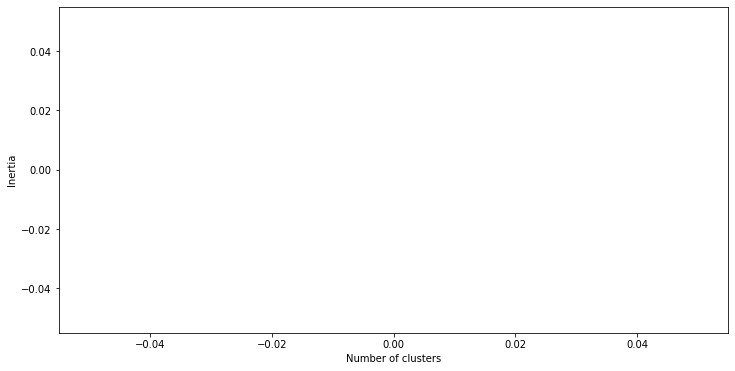

In [8]:
# Try and figure out how many clusters are optimum
# Plot the inertia curve to find the 'elbow'
import h2o4gpu

SSE = []

for cluster in range(1,20):
    kmeans_ss = h2o4gpu.KMeans(n_gpus=1, n_clusters = cluster, init='k-means++', random_state = 42, backend=h2o4gpu)
    %time kmeans_ss.fit(data_scaled)
    SSE.append(kmeans_ss.inertia_)
    print(kmeans_ss.cluster_centers_)
    print(len(SSE))
    print(str(SSE))
    
    # converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [9]:
# Instantiating the KMeans object based on number discovered above
k = 5
kmeans = h2o4gpu.KMeans(n_gpus=1, n_clusters = k, init='k-means++', max_iter = 20, random_state = 42, backend=h2o4gpu)

# Creating the model by passing our non-outlier data to Kmeans object
trained_model = kmeans.fit(data_scaled)

# Retrieving centroids
centroids = kmeans.cluster_centers_

# Labels of KMeans clusters change for every iteration. 
# We need to preserve these lables for runs with multiple/incremental input data sets.
# Creating a hack to attempt to preserve their identities.
# Calculating the arithmetic sum of all values in each centroid. This is done to fix labels for each training iteration
# Assumption is that bigger the values in a centroid, higher the original feature values. This assumption is true only for 
#        data set and our features. We need to definitely confirm/verify this assumption.
combinedCentroids = centroids[trained_model.labels_].sum(axis=1)

# adding column with combined centroid values to the original dataframe 
ml_commits_nout['center'] = combinedCentroids
#print(combinedCentroids)

# Creating a dictionary with combined centroid values and target cluster labels
unique_centroids = np.unique(combinedCentroids).tolist()
cluster_labels = np.arange(k).tolist()
cluster_dict = dict(zip(unique_centroids,cluster_labels))
#print(g)
ml_commits_nout['fixed_cluster'] = ml_commits_nout['center'].map(cluster_dict)
ml_commits_nout

/home/kc/Projects/20200724_h2o4gpu/20200724_h2o4gpu/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/kc/Projects/20200724_h2o4gpu/20200724_h2o4gpu/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,total_changed,ratio_changed,rated_complexity,total_dmm_unit_complexity,total_dmm_size,total_dmm_unit_interfacing,scaled_rated_complexity,Author,hash,center,fixed_cluster
0,14,0.011915,0.941277,14.000000,7.175000,7.525000,3.765106,A. Unique TensorFlower,0ef962b1a5b4e80a7029b0b159af6817b12a04df,0.022421,0
1,75,0.218659,7.653061,75.000000,38.437500,40.312500,30.612245,A. Unique TensorFlower,0ef962b1a5b4e80a7029b0b159af6817b12a04df,0.022421,0
2,4,0.015094,0.075472,4.000000,2.050000,2.150000,0.301887,A. Unique TensorFlower,0ef962b1a5b4e80a7029b0b159af6817b12a04df,0.022421,0
3,47,0.017395,5.670614,47.000000,24.087500,25.262500,22.682457,A. Unique TensorFlower,0ef962b1a5b4e80a7029b0b159af6817b12a04df,0.022421,0
4,19,0.046341,3.104878,18.050000,18.050000,18.050000,12.419512,George Karpenkov,ef47bbbd57cba8fcc7ae11df8c7141d6c68ba0d0,0.022421,0
...,...,...,...,...,...,...,...,...,...,...,...
709757,175,1.000000,0.000000,133.586576,99.679797,156.212240,0.000000,Ben Alpert,a15603d8f1ecdd673d80be318293cee53eb4475d,0.161194,1
709758,41,1.000000,6.000000,31.297426,23.353552,36.598296,2292.000000,Ben Alpert,a15603d8f1ecdd673d80be318293cee53eb4475d,0.161194,1
709759,157,1.000000,1.000000,119.846242,89.427018,140.144696,382.000000,Ben Alpert,a15603d8f1ecdd673d80be318293cee53eb4475d,0.161194,1
709760,574,1.000000,59.000000,438.163968,326.949734,512.376148,22538.000000,Ben Alpert,a15603d8f1ecdd673d80be318293cee53eb4475d,0.575585,2


In [12]:
# Counting each cluster
ml_clustered = ml_commits_nout.groupby(['fixed_cluster'],as_index=True).count()
ml_clustered['hash']
ml_commits_nout[ml_commits_nout['fixed_cluster']==4].head(5)
ml_commits_nout.to_csv('/home/kc/junk/total_commits_clusters_202007281715.csv')

In [ ]:
# ml_commits_nout.columns

In [10]:
# Train the classifier
from xgboost import XGBClassifier
import h2o4gpu as sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Remove text fields
ml_commits_nout_numeric_xg = ml_commits_nout.drop(columns = ['Author','hash','center'])

# Prepare the 'X' and 'Y' for the model
X_ml_commits_nout_numeric_xg = ml_commits_nout_numeric_xg.drop(columns = ['fixed_cluster'])
Y_ml_commits_nout_numeric_xg = ml_commits_nout_numeric_xg['fixed_cluster']

# Split the data for 'Training' and 'Testing' datasets
X_train, X_test, y_train, y_test = train_test_split(X_ml_commits_nout_numeric_xg, Y_ml_commits_nout_numeric_xg, random_state=7)

# Instantiate the model and train it
model = XGBClassifier()
model.fit(X_train, y_train)

# Prediction on Test set.
y_pred = model.predict(X_test)

# Check accuracy
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.9990850869167429


In [ ]:
from h2o4gpu import metrics

metrics.silhouette_score(data_scaled, trained_model.labels_)

In [11]:
# Pickle the XGBoost model
import pickle

filename = '/home/kc/Projects/data_files/finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))